<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

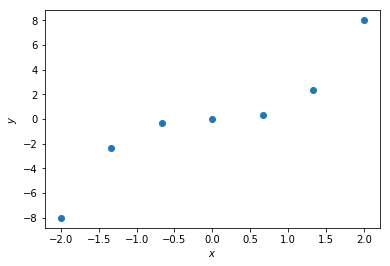

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

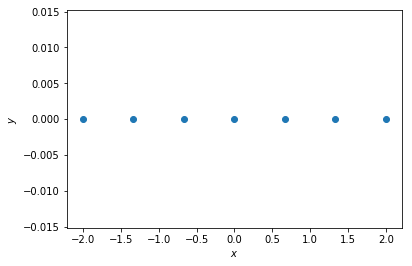

In [115]:
# Ваш код здесь
predict = X * np.mean(X)
plt.scatter(X, predict)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

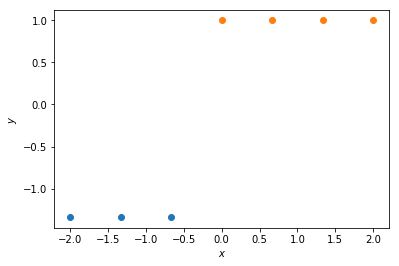

In [27]:
# Ваш код здесь
f_X = X[X<0]
s_X = X[X>=0]
f_leave = np.array([np.mean(f_X) for _ in range(len(f_X))])
s_leave = np.array([np.mean(s_X) for _ in range(len(s_X))])
plt.scatter(f_X, f_leave)
plt.scatter(s_X, s_leave)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [88]:
def build_predict_leave(X):
    return np.array([np.mean(X) for _ in range(len(X))])

def despersion(X, y):
    b = 0
    for i in range(len(X)):
        b += (y[i] - (1/len(X)*sum(y))) ** 2
    return 1/len(X) * b 

def regression_var_criterion(X, y, t):
    common_D = despersion(X,y)
    print(common_D)
    f_X = X[X<t]
    s_X = X[X>=t]
    f_leave = build_predict_leave(f_X)
    s_leave = build_predict_leave(s_X)
    f_D = len(f_X)/len(X)*despersion(f_X, f_leave)
    print(f_D)
    s_D = len(s_X)/len(X) * despersion(s_X, s_leave)
    print(s_D)
    return common_D - f_D - s_D

t_range = np.arange(-1.9, 1.9, 0.1, dtype=float)
# r = [regression_var_criterion(X,y, t) for t in t_range ]
# t_range
# plt.plot(t_range, r)
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$');
regression_var_criterion(X,y,-1)

19.916127768
0.0
0.0


19.916127767979617

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- + Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

[-2.] - mean=[-2.]
[-1.33333333 -0.66666667] - mean=[-1. -1.]
[ 0.          0.66666667  1.33333333] - mean=[ 0.66666667  0.66666667  0.66666667]
[ 2.] - mean=[ 2.]


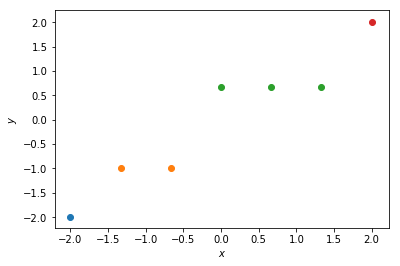

In [112]:
# Ваш код здесь
f_X = X[X<0]
s_X = X[X>=0]
a_X = f_X[f_X < -1.5]
b_X = f_X[f_X >= -1.5]
c_X = s_X[s_X < 1.5]
d_X = s_X[s_X >= 1.5]
a_lev = build_predict_leave(a_X)
b_lev = build_predict_leave(b_X)
c_lev = build_predict_leave(c_X)
d_lev = build_predict_leave(d_X)
print(f'{f_X[f_X < -1.5]} - mean={a_lev}')
print(f'{f_X[f_X >= -1.5]} - mean={b_lev}')
print(f'{s_X[s_X < 1.5]} - mean={c_lev}')
print(f'{s_X[s_X >= 1.5]} - mean={d_lev}')
plt.scatter(a_X, a_lev)
plt.scatter(b_X, b_lev)
plt.scatter(c_X, c_lev)
plt.scatter(d_X, d_lev)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- + 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [29]:
df = pd.read_csv(os.path.join(os.getcwd(),'datasets','mlbootcamp5_train.csv'), sep=';', 
                 index_col='id')

In [30]:
print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [31]:
df['age_years'] = (df['age'] // 365.25).astype(int)
cholesterol = pd.get_dummies(df.pop('cholesterol'), 'cholesterol')
gluc = pd.get_dummies(df.pop('gluc'), 'gluc')
X = pd.concat([df, cholesterol, gluc], axis=1)
y = X.pop('cardio')
X.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [33]:
# Ваш код здесь
clf_tree = DecisionTreeClassifier(random_state=17, max_depth=3).fit(X_train, y_train)
export_graphviz(clf_tree, out_file='small_tree.dot', filled=True, feature_names=X_train.columns)
# для этого понадобится библиотека pydot (pip install pydot)
# !dot -Tpng 'small_tree.dot' -o 'small_tree.png'<img src='small_tree.png'/>

<img src='small_tree2.png'/>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**

- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- + age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [36]:
accuracy_score(clf_tree.predict(X_valid), y_valid)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [42]:
%%time
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(clf_tree,tree_params, cv=5, n_jobs=-1) # Ваш код здесь

tree_grid.fit(X_train, y_train)

Wall time: 17.5 s


Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

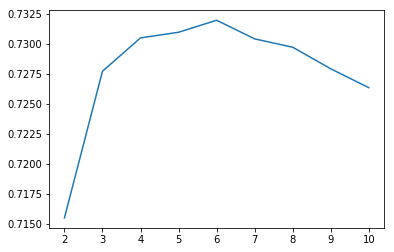

In [62]:
# Ваш код здесь
plt.plot(tree_grid.param_grid['max_depth'],tree_grid.cv_results_['mean_test_score']);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [69]:
# Ваш код здесь
tree_grid.best_score_, accuracy_score(tree_grid.best_estimator_.predict(X_valid), y_valid)
acc1 = accuracy_score(clf_tree.predict(X_valid), y_valid)
acc2 = accuracy_score(tree_grid.best_estimator_.predict(X_valid), y_valid)
(acc2 - acc1)/acc1*100
# print(acc1)
# print(acc2)

0.62718690169670022

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [ ]:
# Ваш код здесь